Import libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing
from matplotlib import pyplot as plt
from statsmodels.multivariate.pca import PCA as PCA
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

Import data

In [2]:
STOCKS=pd.read_excel('DATA_HEALTHCARE.xlsx', 'Healthcare', usecols='B:ZZ')
NAMES=list(STOCKS)
STOCKS=np.array(STOCKS)
SP500=np.array(pd.read_excel('DATA_HEALTHCARE.xlsx', 'MarketIndex', usecols='B'))
DATES=np.array(pd.read_excel('DATA_HEALTHCARE.xlsx', 'Dates', usecols='B'))
END_MONTH_ID=DATES[np.isnan(DATES)==0]

Compute daily returns

In [3]:
RETURNS=STOCKS[1:,:]/STOCKS[:-1,:]-1
n_obs=len(STOCKS)
n_stocks=RETURNS.shape[1]
n_pairs=int((n_stocks*(n_stocks-1))/2)
n_months=len(END_MONTH_ID)

- OUTPUT DATA SETUP

In [4]:
OUT_MONTHLY_PRE_STATIONARY=np.zeros((n_pairs,n_months)) #
OUT_MONTHLY_PRE_HEDGE=np.zeros((n_pairs,n_months)) #
OUT_MONTHLY_PRE_SHORTW=np.zeros((n_pairs,n_months)) #
OUT_MONTHLY_PRE_THETA=np.zeros((n_pairs,n_months)) #
OUT_MONTHLY_PRE_DISTANCE=np.zeros((n_pairs,n_months)) #
OUT_MONTHLY_PRE_ZEROCROSS=np.zeros((n_pairs,n_months)) #

OUT_MONTHLY_POST_HOLDING=np.zeros((n_pairs,n_months)) #
OUT_MONTHLY_POST_PERF_CUM=np.zeros((n_pairs,n_months)) #
OUT_MONTHLY_POST_PERF_AVG=np.zeros((n_pairs,n_months)) #
OUT_MONTHLY_POST_THETA=np.zeros((n_pairs,n_months)) #
OUT_MONTHLY_POST_DISTANCE=np.zeros((n_pairs,n_months)) #
OUT_MONTHLY_POST_ZEROCROSS=np.zeros((n_pairs,n_months)) #

OUT_DAILY_SPREAD=np.zeros((n_pairs,n_obs)) # Spread valuation
OUT_DAILY_SIGNAL=np.zeros((n_pairs,n_obs)) # Trading signal
OUT_DAILY_PERF=np.zeros((n_pairs,n_obs)) # Daily spread perf
OUT_DAILY_DAYS=np.zeros((n_pairs,n_obs)) # Number of days trade open

TIME_LIMIT=30 # MAXIMUM LENGHT OF A TRADE IN TRADING DAYS

- THRESHOLD SETUP

In [5]:
thresholds=np.array([-1.9, -1.5, -0.2, 0.2, 1.5, 1.9])
origin=np.array([-1,0,1])
matrix= np.array([[0,  1,  0, 0,-1, -1, 0],
                  [0,  1,  0, 0, 0, -1, 0],
                  [0,  1,  1, 0, 0, -1, 0]])

- BACKTEST

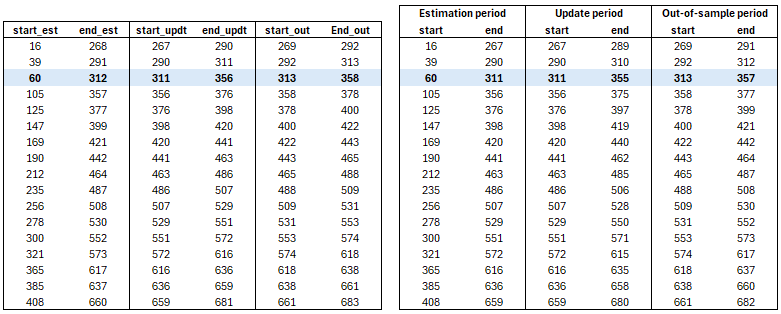

In [6]:
for month in np.arange(12,len(END_MONTH_ID)-1,1):
    ### FOR EACH PAIR
    # ESTIMATION RANGE
    start_est=int(END_MONTH_ID[month]-252)
    end_est=int(END_MONTH_ID[month])
    # UPDATE RANGE
    start_updt=end_est-1
    end_updt=int(END_MONTH_ID[month+1]-1)
    # OUT-OF-SAMPLE RANGE
    start_out=end_est+1
    end_out=end_updt+2
    count=0
    for i in range(n_stocks):
        for j in np.arange(i+1,n_stocks,1):
            
            # HEDGE RATIO (ESTIMATION RANGE)
            mui=np.mean(STOCKS[start_est:end_est,i])
            muj=np.mean(STOCKS[start_est:end_est,j])
            mu1=np.mean(STOCKS[start_est:end_est,1])
            hedge=mui/muj
            OUT_MONTHLY_PRE_HEDGE[count,month]=hedge
            OUT_MONTHLY_PRE_SHORTW[count,month]=hedge*STOCKS[end_est,j]/STOCKS[end_est,i]            
            
            # SPREAD - NORMALIZED (ESTIMATION RANGE)
            SPREADp=np.log(STOCKS[start_est:end_est,i])-np.log(hedge*STOCKS[start_est:end_est,j])
            SPREADbase=np.log(STOCKS[start_est:end_est,i]/mu1)-np.log(hedge*STOCKS[start_est:end_est,j]/mu1)
            m=np.mean(SPREADp)
            std=np.std(SPREADp)
            SPREAD=(SPREADp-m)/std
            
            # STATIONARITY TEST - ADF
            pval=adfuller(SPREAD, regression='c')[1]
            OUT_MONTHLY_PRE_STATIONARY[count,month]=(pval<0.05)
            
            # OU MODEL
            D_SPREAD=SPREAD[1:]-SPREAD[:-1]
            ou_model=sm.OLS(D_SPREAD,sm.add_constant(SPREAD[:-1]))
            ou_out=ou_model.fit()
            OUT_MONTHLY_PRE_THETA[count,month]=-ou_out.params[1]
            
            # EUCLIDEAN DISTANCE
            OUT_MONTHLY_PRE_DISTANCE[count,month]=np.sqrt(sum(np.square(SPREADbase)))
            #OUT_MONTHLY_PRE_DISTANCE[count,month]=np.sqrt(sum(np.square(SPREADp)))
            # NUMBER OF ZERO-CROSSINGS
            OUT_MONTHLY_PRE_ZEROCROSS[count,month]=sum((SPREAD[1:]/SPREAD[:-1])<0) 
            
            # FOR STATIONARY SPREADS
            if pval<0.05:
                
                # DAILY SPREAD (UPDATE RANGE)
                daily_spread=(np.log(STOCKS[start_updt:end_updt,i])-np.log(hedge*STOCKS[start_updt:end_updt,j])-m)/std
                
                # DAILY INTRA-MONTH TRADE SIGNALS (UPDATE RANGE)
                position=np.zeros(daily_spread.shape)
                
                ##############################################################################
                # FIRST DATE: IN THE CASE A PAIR IS BEING ALREADY TRADED, CONTINUE THE TRADE #
                ##############################################################################
                close_trade=0
                already_trading=abs(OUT_DAILY_SIGNAL[count,start_updt-1])>0
                if already_trading==1:
                    
                    ### COMPUTE THE NEW POSITION
                    pos_old=OUT_DAILY_SIGNAL[count,start_updt-1]
                    s=daily_spread[0]
                    row=np.where(origin==pos_old)[0][0]
                    col=np.searchsorted(thresholds,s)
                    position[0]=matrix[row,col]
                    
                    ### IF THE TRADE IS CLOSED
                    if position[0]==0:
                        close_trade=1
                        # POST STATS OF THE CLOSED TRADE
                        trade_lenght=int(OUT_DAILY_DAYS[count,start_updt-1])
                        OUT_MONTHLY_POST_HOLDING[count,month]=trade_lenght
                        OUT_MONTHLY_POST_PERF_CUM[count,month]=np.cumprod(1+OUT_DAILY_PERF[count,start_out-trade_lenght:start_out])[-1]-1
                        OUT_MONTHLY_POST_PERF_AVG[count,month]=np.mean(OUT_DAILY_PERF[count,start_out-trade_lenght:start_out])
                        OUT_MONTHLY_POST_THETA[count,month]=OUT_MONTHLY_PRE_THETA[count,month-1]
                        OUT_MONTHLY_POST_DISTANCE[count,month]=OUT_MONTHLY_PRE_DISTANCE[count,month-1]
                        OUT_MONTHLY_POST_ZEROCROSS[count,month]=OUT_MONTHLY_PRE_ZEROCROSS[count,month-1]
                        
                    ### IF THE TRADE REMAINS OPEN
                    if abs(position[0])>0:
                        # TIME TRADE OPEN
                        OUT_DAILY_DAYS[count,start_updt]=OUT_DAILY_DAYS[count,start_updt-1]+1
                        OUT_DAILY_SIGNAL[count,start_updt]=position[0]
                        # DAILY PERF
                        D_P1=STOCKS[start_out,i]-STOCKS[start_out-1,i]
                        D_P2=STOCKS[start_out,j]-STOCKS[start_out-1,j]
                        P1_1=STOCKS[start_out-1,i]
                        P2_1=STOCKS[start_out-1,j]
                        OUT_DAILY_PERF[count,start_out]=(D_P1-hedge*D_P2)/(P1_1+hedge*P2_1)
                        OUT_DAILY_SPREAD[count,start_updt]=daily_spread[0]
                
                #################################################################################
                # FIRST DATE: IN THE CASE A PAIR WAS NOT TRADED, AND TRADING SIGNAL IS OBSERVED #
                #################################################################################
                signal_open=sum((daily_spread[0]>thresholds[4:])+(daily_spread[0]<thresholds[:2]))
                if ((already_trading==0)*(signal_open==1))==1:
                    
                    ### COMPUTE THE POSITION
                    position[0]=(2*(daily_spread[0]<0))-1
                    
                    ### DAILY STATS
                    
                    # TIME TRADE OPEN
                    OUT_DAILY_DAYS[count,start_updt]=1
                    OUT_DAILY_SIGNAL[count,start_updt]=position[0]
                    
                    # DAILY PERF
                    D_P1=STOCKS[start_out,i]-STOCKS[start_out-1,i]
                    D_P2=STOCKS[start_out,j]-STOCKS[start_out-1,j]
                    P1_1=STOCKS[start_out-1,i]
                    P2_1=STOCKS[start_out-1,j]
                    OUT_DAILY_PERF[count,start_out]=(D_P1-hedge*D_P2)/(P1_1+hedge*P2_1)
                    OUT_DAILY_SPREAD[count,start_updt]=daily_spread[0]

                ####################
                # SUBSEQUENT DATES #
                ####################
                for t in np.arange(1,len(daily_spread),1):
                    
                    ### DO NOT TRADE THE PAIR THIS MONTH IF THE TRADE HAS BEEN CLOSED ON THE FIRT DAY
                    if close_trade==1:
                        break
                        
                    ### NEW POSITION
                    pos_old=position[t-1]
                    s=daily_spread[t]
                    row=np.where(origin==pos_old)[0][0]
                    col=np.searchsorted(thresholds,s)
                    position[t]=matrix[row,col]

                    ### EXIT THE TRADE FOR THE MONTH IF STOP LOSS OR STOP GAIN REACHED
                    if ((abs(position[t-1])>0)*(position[t]==0))==1:
                        trade_lenght=int(OUT_DAILY_DAYS[count,start_updt+t-1])
                        # STATS OF THE CLOSED TRADE
                        trade_lenght=int(OUT_DAILY_DAYS[count,start_updt+t-1])
                        OUT_MONTHLY_POST_HOLDING[count,month]=trade_lenght
                        OUT_MONTHLY_POST_PERF_CUM[count,month]=np.cumprod(1+OUT_DAILY_PERF[count,start_out-trade_lenght+t:start_out+t])[-1]-1
                        OUT_MONTHLY_POST_PERF_AVG[count,month]=np.mean(OUT_DAILY_PERF[count,start_out-trade_lenght+t:start_out+t])
                        OUT_MONTHLY_POST_THETA[count,month]=OUT_MONTHLY_PRE_THETA[count,month]
                        OUT_MONTHLY_POST_DISTANCE[count,month]=OUT_MONTHLY_PRE_DISTANCE[count,month]
                        OUT_MONTHLY_POST_ZEROCROSS[count,month]=OUT_MONTHLY_PRE_ZEROCROSS[count,month]
                        break

                    ### EXIT THE TRADE FOR THE MONTH IF THE TIME LIMIT IS REACHED
                    if OUT_DAILY_DAYS[count,start_updt+t-1]==TIME_LIMIT:
                        trade_lenght=int(OUT_DAILY_DAYS[count,start_updt+t-1])
                        # STATS OF THE CLOSED TRADE
                        OUT_MONTHLY_POST_HOLDING[count,month]=trade_lenght
                        OUT_MONTHLY_POST_PERF_CUM[count,month]=np.cumprod(1+OUT_DAILY_PERF[count,start_out-trade_lenght+t:start_out+t])[-1]-1
                        OUT_MONTHLY_POST_PERF_AVG[count,month]=np.mean(OUT_DAILY_PERF[count,start_out-trade_lenght+t:start_out+t])
                        OUT_MONTHLY_POST_THETA[count,month]=OUT_MONTHLY_PRE_THETA[count,month]
                        OUT_MONTHLY_POST_DISTANCE[count,month]=OUT_MONTHLY_PRE_DISTANCE[count,month]
                        OUT_MONTHLY_POST_ZEROCROSS[count,month]=OUT_MONTHLY_PRE_ZEROCROSS[count,month]
                        break                      
                        
                    ### IF TRADED, UPDATE DAILY DATA
                    if abs(position[t])==1:
                        OUT_DAILY_DAYS[count,start_updt+t]=OUT_DAILY_DAYS[count,start_updt+t-1]+1
                        OUT_DAILY_SIGNAL[count,start_updt+t]=position[t]
                        # DAILY PERF
                        D_P1=STOCKS[start_out+t,i]-STOCKS[start_out+t-1,i]
                        D_P2=STOCKS[start_out+t,j]-STOCKS[start_out+t-1,j]
                        P1_1=STOCKS[start_out+t-1,i]
                        P2_1=STOCKS[start_out+t-1,j]
                        OUT_DAILY_PERF[count,start_out+t]=(D_P1-hedge*D_P2)/(P1_1+hedge*P2_1)
                        OUT_DAILY_SPREAD[count,start_updt+t]=daily_spread[t]

            count=count+1
    print(month)
    
TRADE_ID=np.transpose(np.nonzero(OUT_MONTHLY_POST_HOLDING))
DIST_HOLDING=np.zeros((len(TRADE_ID)))
DIST_PERF_CUM=np.zeros((len(TRADE_ID)))
DIST_PERF_AVG=np.zeros((len(TRADE_ID)))
DIST_THETA=np.zeros((len(TRADE_ID)))
DIST_ZEROX=np.zeros((len(TRADE_ID)))
DIST_DISTANCE=np.zeros((len(TRADE_ID)))


for i in range(len(TRADE_ID)):
    DIST_HOLDING[i]=OUT_MONTHLY_POST_HOLDING[TRADE_ID[i,0],TRADE_ID[i,1]]
    DIST_PERF_CUM[i]=OUT_MONTHLY_POST_PERF_CUM[TRADE_ID[i,0],TRADE_ID[i,1]]
    DIST_PERF_AVG[i]=OUT_MONTHLY_POST_PERF_AVG[TRADE_ID[i,0],TRADE_ID[i,1]]
    DIST_THETA[i]=OUT_MONTHLY_POST_THETA[TRADE_ID[i,0],TRADE_ID[i,1]]
    DIST_ZEROX[i]=OUT_MONTHLY_POST_ZEROCROSS[TRADE_ID[i,0],TRADE_ID[i,1]]
    DIST_DISTANCE[i]=OUT_MONTHLY_POST_DISTANCE[TRADE_ID[i,0],TRADE_ID[i,1]]

12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


[]

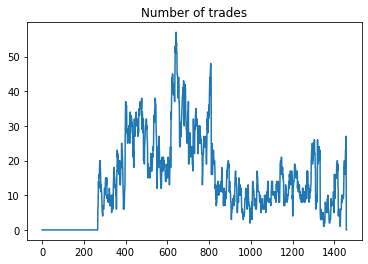

In [7]:
N_TRADES=np.sum(abs(OUT_DAILY_SIGNAL)>0,axis=0)
plt.plot(N_TRADES)
plt.title("Number of trades")
plt.plot()

[]

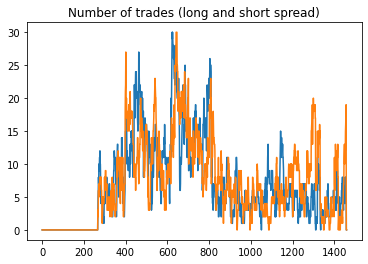

In [8]:
N_TRADES_L=np.sum(OUT_DAILY_SIGNAL==1,axis=0)
N_TRADES_S=np.sum(OUT_DAILY_SIGNAL==-1,axis=0)
plt.plot(N_TRADES_L)
plt.plot(N_TRADES_S)
plt.title("Number of trades (long and short spread)")
plt.plot()

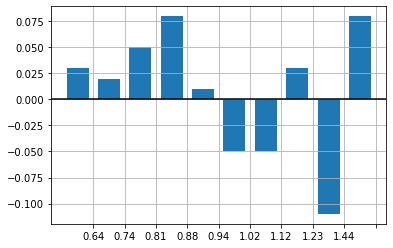

In [9]:
n=10
data=DIST_DISTANCE
ref=np.searchsorted(np.quantile(data ,np.arange(1,n,1)/n),data)
out_cond=np.zeros((n))
for i in range(n):
    out_cond[i]=np.mean(DIST_PERF_AVG[ref==i])

cats=np.append(np.round(np.quantile(data,np.arange(1,n,1)/n),2),'')
x=np.arange(len(cats)) + 0.5
y=np.round(out_cond*100,2)

plt.bar(x,y,width=0.7)
plt.axhline(y=0, color='k')
plt.grid(True, which='both')
plt.xticks(x+0.5, cats)
plt.show()

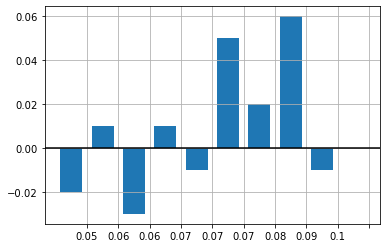

In [10]:
n=10
data=DIST_THETA
ref=np.searchsorted(np.quantile(data ,np.arange(1,n,1)/n),data)
out_cond=np.zeros((n))
for i in range(n):
    out_cond[i]=np.mean(DIST_PERF_AVG[ref==i])

cats=np.append(np.round(np.quantile(data,np.arange(1,n,1)/n),2),'')
x=np.arange(len(cats)) + 0.5
y=np.round(out_cond*100,2)

plt.bar(x,y,width=0.7)
plt.axhline(y=0, color='k')
plt.grid(True, which='both')
plt.xticks(x+0.5, cats)
plt.show()

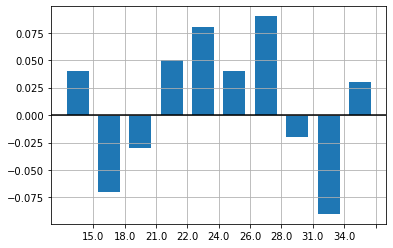

In [11]:
n=10
data=DIST_ZEROX
ref=np.searchsorted(np.quantile(data ,np.arange(1,n,1)/n),data)
out_cond=np.zeros((n))
for i in range(n):
    out_cond[i]=np.mean(DIST_PERF_AVG[ref==i])

cats=np.append(np.round(np.quantile(data,np.arange(1,n,1)/n),2),'')
x=np.arange(len(cats)) + 0.5
y=np.round(out_cond*100,2)

plt.bar(x,y,width=0.7)
plt.axhline(y=0, color='k')
plt.grid(True, which='both')
plt.xticks(x+0.5, cats)
plt.show()

[]

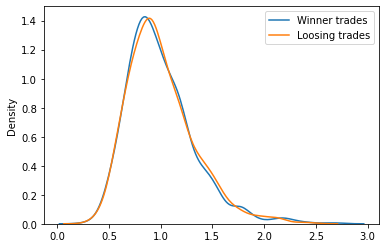

In [12]:
pos=DIST_PERF_CUM>0
neg=DIST_PERF_CUM<0
dist_pos=DIST_DISTANCE[pos]
dist_neg=DIST_DISTANCE[neg]

sns.distplot(dist_pos, hist=False, kde=True, bins=150)
sns.distplot(dist_neg, hist=False, kde=True, bins=150)
plt.legend(["Winner trades","Loosing trades"])
plt.plot()

[]

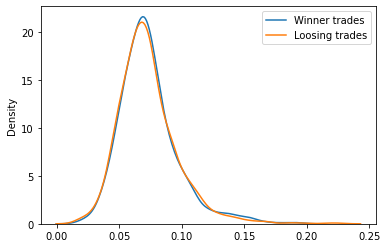

In [13]:
pos=DIST_PERF_CUM>0
neg=DIST_PERF_CUM<0
dist_pos=DIST_THETA[pos]
dist_neg=DIST_THETA[neg]

sns.distplot(dist_pos, hist=False, kde=True, bins=150)
sns.distplot(dist_neg, hist=False, kde=True, bins=150)
plt.legend(["Winner trades","Loosing trades"])
plt.plot()

[]

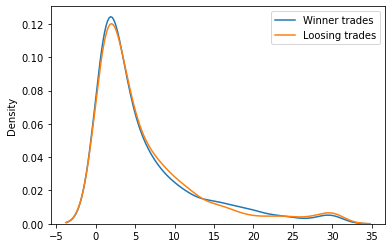

In [14]:
pos=DIST_PERF_CUM>0
neg=DIST_PERF_CUM<0
dist_pos=DIST_HOLDING[pos]
dist_neg=DIST_HOLDING[neg]

sns.distplot(dist_pos, hist=False, kde=True, bins=150)
sns.distplot(dist_neg, hist=False, kde=True, bins=150)
plt.legend(["Winner trades","Loosing trades"])
plt.plot()

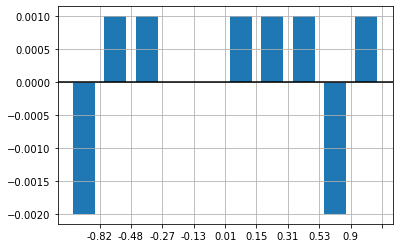

In [15]:
n=10
ref=np.searchsorted(np.quantile(DIST_PERF_AVG ,np.arange(1,n,1)/n),DIST_PERF_AVG)
out_cond=np.zeros((n))
for i in range(n):
    out_cond[i]=np.mean(DIST_THETA[ref==i])-np.mean(DIST_THETA)

cats=np.append(np.round(np.quantile(DIST_PERF_AVG,np.arange(1,n,1)/n)*100,2),'')
x=np.arange(len(cats)) + 0.5
y=np.round(out_cond,3)

plt.bar(x,y,width=0.7)
plt.axhline(y=0, color='k')
plt.grid(True, which='both')
plt.xticks(x+0.5, cats)
plt.show()

In [16]:
np.mean(out_cond)

1.0027754275235278e-06

In [17]:
DIST_HOLDING

array([ 3.,  3.,  6., ...,  3., 10.,  2.])

In [18]:
print(DIST_HOLDING)

[ 3.  3.  6. ...  3. 10.  2.]
